# Notes

* This kernel is cover baseline modeling with XGBoost

# Load libs

In [1]:
import os
import gc
import datetime

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

import xgboost as xgb

import warnings
warnings.simplefilter('ignore', FutureWarning)

print(os.listdir("../input"))

['sample_submission.csv', 'new_merchant_transactions.csv', 'merchants.csv', 'Data_Dictionary.xlsx', 'Data Dictionary.xlsx', 'historical_transactions.csv', 'train.csv', 'test.csv']


# Load datasets

In [2]:
train = pd.read_csv('../input/train.csv', parse_dates=["first_active_month"])
test = pd.read_csv('../input/test.csv', parse_dates=["first_active_month"])

merchants = pd.read_csv('../input/merchants.csv')
historical_transactions = pd.read_csv('../input/historical_transactions.csv')
new_merchant_transactions = pd.read_csv('../input/new_merchant_transactions.csv')

sample_submission = pd.read_csv('../input/sample_submission.csv')

In [3]:
train.shape, test.shape, sample_submission.shape

((201917, 6), (123623, 5), (123623, 2))

In [4]:
merchants.shape, historical_transactions.shape, new_merchant_transactions.shape

((334696, 22), (29112361, 14), (1963031, 14))

In [5]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749


In [6]:
merchants.head()

,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,avg_purchases_lag3,active_months_lag3,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
0,M_ID_838061e48c,8353,792,9,-0.057471,-0.057471,N,E,E,-0.40,9.666667,3,-2.25,18.666667,6,-2.32,13.916667,12,N,242,9,1.0
1,M_ID_9339d880ad,3184,840,20,-0.057471,-0.057471,N,E,E,-0.72,1.750000,3,-0.74,1.291667,6,-0.57,1.687500,12,N,22,16,1.0
2,M_ID_e726bbae1e,447,690,1,-0.057471,-0.057471,N,E,E,-82.13,260.000000,2,-82.13,260.000000,2,-82.13,260.000000,2,N,-1,5,5.0
3,M_ID_a70e9c5f81,5026,792,9,-0.057471,-0.057471,Y,E,E,NaN,1.666667,3,NaN,4.666667,6,NaN,3.833333,12,Y,-1,-1,NaN
4,M_ID_64456c37ce,2228,222,21,-0.057471,-0.057471,Y,E,E,NaN,0.500000,3,NaN,0.361111,6,NaN,0.347222,12,Y,-1,-1,NaN


In [7]:
historical_transactions.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


In [8]:
new_merchant_transactions.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.0,9,19
2,Y,C_ID_415bb3a509,330,N,1,B,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,1.0,9,14
3,Y,C_ID_415bb3a509,-1,Y,1,B,661,M_ID_9e84cda3b1,1,-0.671925,2018-03-07 09:43:21,NaN,-1,8
4,Y,C_ID_ef55cf8d4b,-1,Y,1,B,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,NaN,-1,29


# Preprocessing


In [9]:
def missing_impute(df):
    for i in df.columns:
        if df[i].dtype == "object":
            df[i] = df[i].fillna("other")
        elif (df[i].dtype == "int64" or df[i].dtype == "float64"):
            df[i] = df[i].fillna(df[i].mean())
        else:
            pass
    return df

def datetime_extract(df, dt_col='first_active_month'):
    df['date'] = df[dt_col].dt.date 
    df['day'] = df[dt_col].dt.day 
    df['dayofweek'] = df[dt_col].dt.dayofweek
    df['dayofyear'] = df[dt_col].dt.dayofyear
    df['days_in_month'] = df[dt_col].dt.days_in_month
    df['daysinmonth'] = df[dt_col].dt.daysinmonth 
    df['month'] = df[dt_col].dt.month
    df['week'] = df[dt_col].dt.week 
    df['weekday'] = df[dt_col].dt.weekday
    df['weekofyear'] = df[dt_col].dt.weekofyear
    df['year'] = train[dt_col].dt.year
    
    df['elapsed_time'] = (datetime.date(2018, 2, 1) - df['date']).dt.days

    return df


# Do impute missing values for all datasets
for df in [train, test, merchants, historical_transactions, new_merchant_transactions]:
    missing_impute(df)
    

# Do extract datetime values for train and test
train = datetime_extract(train, dt_col='first_active_month')
test = datetime_extract(test, dt_col='first_active_month')

## Merge with historical transactions

In [10]:
# Define the aggregation procedure outside of the groupby operation
aggregations = {
    'purchase_amount': ['sum', 'mean', 'std', 'min', 'max', 'size', 'median']
}

grouped = historical_transactions.groupby('card_id').agg(aggregations)
grouped.columns = grouped.columns.droplevel(level=0)
grouped.rename(columns={
    "sum": "sum_purchase_amount", 
    "mean": "mean_purchase_amount",
    "std": "std_purchase_amount", 
    "min": "min_purchase_amount",
    "max": "max_purchase_amount", 
    "size": "num_purchase_amount",
    "median": "median_purchase_amount"
}, inplace=True)
grouped.reset_index(inplace=True)

train = pd.merge(train, grouped, on="card_id", how="left")
test = pd.merge(test, grouped, on="card_id", how="left")

del grouped
gc.collect()

64

## Merge with new merchant

In [11]:
# Define the aggregation procedure outside of the groupby operation
aggregations = {
    'purchase_amount': ['sum', 'mean', 'std', 'min', 'max', 'size', 'median']
}

grouped = new_merchant_transactions.groupby('card_id').agg(aggregations)
grouped.columns = grouped.columns.droplevel(level=0)
grouped.rename(columns={
    "sum": "sum_purchase_amount", 
    "mean": "mean_purchase_amount",
    "std": "std_purchase_amount", 
    "min": "min_purchase_amount",
    "max": "max_purchase_amount", 
    "size": "num_purchase_amount",
    "median": "median_purchase_amount"
}, inplace=True)
grouped.reset_index(inplace=True)

train = pd.merge(train, grouped, on="card_id", how="left")
test = pd.merge(test, grouped, on="card_id", how="left")

del grouped
gc.collect()

42

In [12]:
train.shape, test.shape

((201917, 32), (123623, 31))

In [13]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,date,day,dayofweek,dayofyear,days_in_month,daysinmonth,month,week,weekday,weekofyear,year,elapsed_time,sum_purchase_amount_x,mean_purchase_amount_x,std_purchase_amount_x,min_purchase_amount_x,max_purchase_amount_x,num_purchase_amount_x,median_purchase_amount_x,sum_purchase_amount_y,mean_purchase_amount_y,std_purchase_amount_y,min_purchase_amount_y,max_purchase_amount_y,num_purchase_amount_y,median_purchase_amount_y
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283,2017-06-01,1,3,152,30,30,6,22,3,22,2017,245,-165.968739,-0.638341,0.212139,-0.739395,2.258395,260,-0.698042,-13.244202,-0.575835,0.135812,-0.724368,-0.296112,23.0,-0.581180
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913,2017-01-01,1,6,1,31,31,1,52,6,52,2017,396,-210.006336,-0.600018,0.384967,-0.742400,4.630299,350,-0.708590,-4.355735,-0.725956,0.014326,-0.739410,-0.701858,6.0,-0.732633
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056,2016-08-01,1,0,214,31,31,8,31,0,31,2016,549,-29.167391,-0.678311,0.087380,-0.730138,-0.145847,43,-0.698868,-0.700326,-0.700326,NaN,-0.700326,-0.700326,1.0,-0.700326
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495,2017-09-01,1,4,244,30,30,9,35,4,35,2017,153,-49.491364,-0.642745,0.261624,-0.740897,1.445596,77,-0.707989,-4.654372,-0.664910,0.065882,-0.734135,-0.566740,7.0,-0.691610
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749,2017-11-01,1,2,305,30,30,11,44,2,44,2017,92,-48.687656,-0.366073,1.352094,-0.746156,7.193041,133,-0.689807,-19.926237,-0.553507,0.223821,-0.739395,0.450886,36.0,-0.607447


# One Hot Encoding

In [14]:
# One-hot encode features
ohe_df_1 = pd.get_dummies(train['feature_1'], prefix='f1_')
ohe_df_2 = pd.get_dummies(train['feature_2'], prefix='f2_')
ohe_df_3 = pd.get_dummies(train['feature_3'], prefix='f3_')

ohe_df_4 = pd.get_dummies(test['feature_1'], prefix='f1_')
ohe_df_5 = pd.get_dummies(test['feature_2'], prefix='f2_')
ohe_df_6 = pd.get_dummies(test['feature_3'], prefix='f3_')

# Numerical representation of the first active month
train = pd.concat([train, ohe_df_1, ohe_df_2, ohe_df_3], axis=1, sort=False)
test = pd.concat([test, ohe_df_4, ohe_df_5, ohe_df_6], axis=1, sort=False)

del ohe_df_1, ohe_df_2, ohe_df_3
del ohe_df_4, ohe_df_5, ohe_df_6
gc.collect()

49

In [15]:
train.shape, test.shape

((201917, 42), (123623, 41))

In [16]:
excluded_features = ['first_active_month', 'card_id', 'target', 'date', 'year']
train_features = [c for c in train.columns if c not in excluded_features]

## Final fill NA

In [17]:
# Final fill missing values
for col in train_features:
    for df in [train, test]:
        if df[col].dtype == "float64":
            df[col] = df[col].fillna(df[col].mean())

# XGBoost training

In [18]:
# Prepare data for training
X = train.copy()
y = X['target']

# Split data with kfold
kfolds = KFold(n_splits=5, shuffle=True, random_state=2018)

# Make importance dataframe
importances = pd.DataFrame()

oof_preds = np.zeros(X.shape[0])
sub_preds = np.zeros(test.shape[0])

for n_fold, (trn_idx, val_idx) in enumerate(kfolds.split(X, y)):
    X_train, y_train = X[train_features].iloc[trn_idx], y.iloc[trn_idx]
    X_valid, y_valid = X[train_features].iloc[val_idx], y.iloc[val_idx]
    
    # XGBoost Regressor estimator
    model = xgb.XGBRegressor(
        max_depth = 15,
        learning_rate = 0.01,
        n_estimators = 1000,
        subsample = .9,
        colsample_bylevel = .9,
        colsample_bytree = .9,
        min_child_weight= .9,
        gamma = 0,
        random_state = 100,
        booster = 'gbtree',
        objective = 'reg:linear'
    )
    
    # Fit
    model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        verbose=True, eval_metric='rmse',
        early_stopping_rounds=100
    )
    
    # Feature importance
    imp_df = pd.DataFrame()
    imp_df['feature'] = train_features
    imp_df['gain'] = model.feature_importances_
    imp_df['fold'] = n_fold + 1
    importances = pd.concat([importances, imp_df], axis=0, sort=False)
    
    oof_preds[val_idx] = model.predict(X_valid)
    test_preds = model.predict(test[train_features])
    sub_preds += test_preds / kfolds.n_splits
    
print(np.sqrt(mean_squared_error(y, oof_preds)))

[0]	validation_0-rmse:3.9424	validation_1-rmse:3.95759
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:3.93265	validation_1-rmse:3.95479
[2]	validation_0-rmse:3.92317	validation_1-rmse:3.95228
[3]	validation_0-rmse:3.91393	validation_1-rmse:3.94968
[4]	validation_0-rmse:3.90516	validation_1-rmse:3.9471
[5]	validation_0-rmse:3.8956	validation_1-rmse:3.9446
[6]	validation_0-rmse:3.88706	validation_1-rmse:3.9422
[7]	validation_0-rmse:3.87922	validation_1-rmse:3.93998
[8]	validation_0-rmse:3.87017	validation_1-rmse:3.93768
[9]	validation_0-rmse:3.86133	validation_1-rmse:3.93544
[10]	validation_0-rmse:3.85337	validation_1-rmse:3.93315
[11]	validation_0-rmse:3.84495	validation_1-rmse:3.93108
[12]	validation_0-rmse:3.83658	validation_1-rmse:3.92886
[13]	validation_0-rmse:3.8282	validation_1-rmse:3.92687
[14]	validation_0-rmse:3.8198	validation_1-rmse:3.92482
[1

# Feature Importances

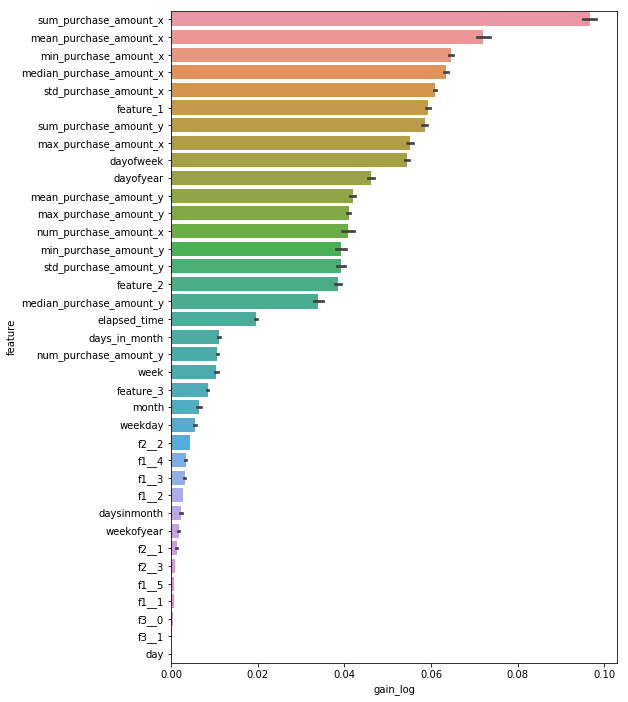

In [19]:
importances['gain_log'] = importances['gain']
mean_gain = importances[['gain', 'feature']].groupby('feature').mean()
importances['mean_gain'] = importances['feature'].map(mean_gain['gain'])

plt.figure(figsize=(8, 12))
sns.barplot(x='gain_log', y='feature', data=importances.sort_values('mean_gain', ascending=False))

# Make submission

In [20]:
# Length of submission
len(sub_preds)

123623

In [21]:
sub_preds

array([-0.61836685, -0.63381638, -0.72022741, ..., -0.4235671 ,
       -0.27179863, -0.49216813])

In [22]:
# Make submission
sample_submission['target'] = sub_preds
sample_submission.to_csv("xgb_submission.csv", index=False)
sample_submission.head()

,card_id,target
0,C_ID_0ab67a22ab,-0.618367
1,C_ID_130fd0cbdd,-0.633816
2,C_ID_b709037bc5,-0.720227
3,C_ID_d27d835a9f,-0.086126
4,C_ID_2b5e3df5c2,-1.592783
